# Capstone Project


# Title - Fraud Analysis Using ML Algorithms

## PGCP DSML IITR-TimesPro


### Submitted by - Sylvia Chadha


# Problem Statement

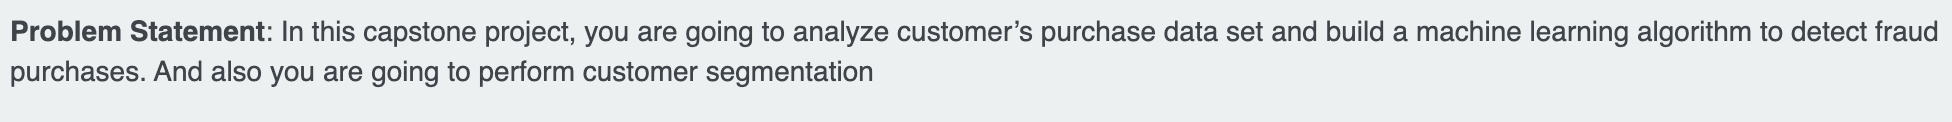

## Objectives 
There are two objectives in this Project-

1. To detect Fraud Purchases
2. To perform customer segmentation

# Dataset Description

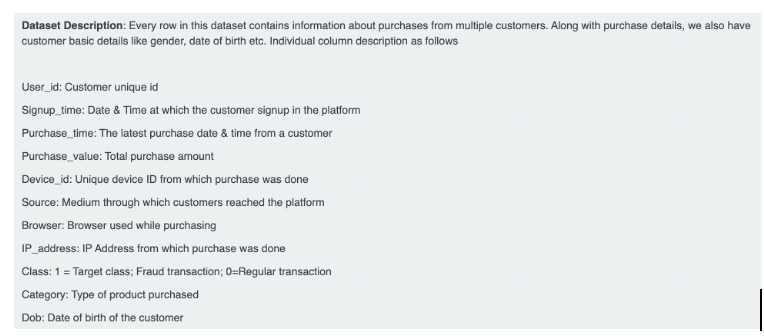

# Objective1 - Fraud Detection

# Table of Contents

<font color=blue>
    
- Data Aquisition & Cleaning
- Exploratory Data Analysis
- Base Model for Benchmark
- Feature Engineering
- Model Training 
- Hyperparameter Tuning
- Model Evaluation 


# 1. Dataset Aquisition & Preprocessing


Loading data, exploring dataset and the necessary data cleaning.

In [33]:
# Import Libraries

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,classification_report
from mlxtend.plotting import plot_confusion_matrix  # For plotting confusion matrix

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,cross_val_score, cross_validate


pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


In [34]:
# Read data file

df = pd.read_csv('Purchase_Fraud_Data.csv')

df.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,57296,YSSKYOSJHPPLJ,SEO,Opera,M,2.621474e+09,1,electronics,5-3-1962


In [35]:
df.shape

(151112, 12)

There are 151112 rows/samples and 12 columns/features.

In [36]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             146185 non-null  object 
 8   ip_address      151112 non-null  float64
 9   class           151112 non-null  int64  
 10  category        151112 non-null  object 
 11  dob             146188 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 13.8+ MB


<font color=blue>Data Types - Summarizing numerical, categorical and date columns

In [37]:
numerical_cols = df.select_dtypes(include=["int64","float64"]).columns
numerical_cols

Index(['user_id', 'purchase_value', 'ip_address', 'class'], dtype='object')

In [38]:
cat_cols = df.select_dtypes(include="object").columns
cat_cols

Index(['signup_time', 'purchase_time', 'device_id', 'source', 'browser', 'sex',
       'category', 'dob'],
      dtype='object')

In [39]:
df.select_dtypes("object").nunique()

signup_time      151112
purchase_time    150663
device_id        137956
source                3
browser               5
sex                   2
category              5
dob               13745
dtype: int64

In [40]:
df['user_id'].nunique()

151112

In [41]:
df['ip_address'].nunique()

143512

In [42]:
df['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

**Inferences**

- The `user_id` is like an identifier column as it has unique value for each record in dataset.


- `signup_time`, `purchase_time`, `dob` are identified as object data types however they need to be converted to date-time and to extract year, month,day and time features.


- `device_id` and `ip-address` have 137956 &  143512 unique values out of total 151112 records in dataset implying these are v.high cardinality features.


- Fraud transactions are very less compared to non-fraud transactions implying `imbalance in distribution` of target variable.

<font color=blue>Missing Values - Identifing and perform missing value treatment

In [43]:
missing = df.isnull().sum()
missing

user_id              0
signup_time          0
purchase_time        0
purchase_value       0
device_id            0
source               0
browser              0
sex               4927
ip_address           0
class                0
category             0
dob               4924
dtype: int64

*Handle Missing values for `sex` and `dob`*

*We handle this missing value treatment after data split we we need to fit_transform on train data & only transform on test data to avoid data leakage*

# 2. Exploratory Data Analysis


To understand the distribution of the data, identify patterns and trends, and uncover any relationships or correlations between variables. This helps in gaining insights.

### 2a. Univariate analysis: Distribution analysis for numerical columns and frequency analysis for categorical columns)

*<font color=blue>Target Variable*

In [44]:
fraud = df['class'].value_counts()
fraud

0    136961
1     14151
Name: class, dtype: int64

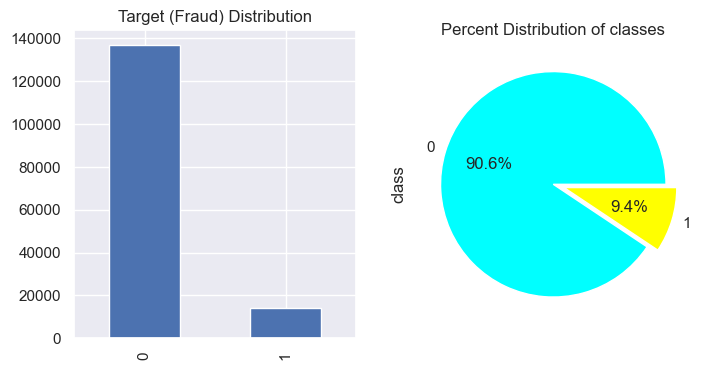

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1,ncols=2)

explode=(0,0.1)
fraud.plot(kind='bar',title=('Target (Fraud) Distribution'),figsize=(5,3), ax=ax[0])
fraud.plot(kind='pie', title='Percent Distribution of classes',explode=explode,autopct='%1.1f%%', colors=['cyan','yellow'],
              figsize=(8,4), ax=ax[1]);


We see that the number of Fraud cases are just 9.4% of the total available data.

*<font color=blue>Numerical Features*

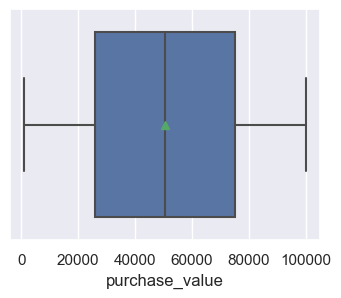

In [46]:
sns.set(rc={"figure.figsize":(4, 3)}) #width=4, #height=3
sns.boxplot(x = df['purchase_value'], showmeans = True)  
plt.show()

In [47]:
print('Mean & Median for Purchase value', round(df['purchase_value'].mean(),1), 
                                          df['purchase_value'].median())


Mean & Median for Purchase value 50521.5 50484.0


In [48]:
q1 = np.percentile(df['purchase_value'], 25)
q3 = np.percentile(df['purchase_value'], 75)
q1,q3

(25919.0, 75296.25)

- We see that the `mean as well as median` value for the purchase_value is about 50K.
- 50% of transactions are in `range` of about about 25K to 75K.

*<font color=blue>Categorical Features*

In [49]:
# Unique Values in each categorical column-
cat_cols = ['source','browser','sex','category','user_id', 'device_id','ip_address']

for i in df[cat_cols]:
    print("\033[1m" + i + "\033[0m")
    print('Unique values:',df[i].unique())
    print('Total unique values:',df[i].nunique(),'\n')

source
Unique values: ['SEO' 'Ads' 'Direct']
Total unique values: 3 

browser
Unique values: ['Chrome' 'Opera' 'Safari' 'IE' 'FireFox']
Total unique values: 5 

sex
Unique values: ['M' 'F' nan]
Total unique values: 2 

category
Unique values: ['home_essentials' 'apparels' 'electronics' 'health_care' 'cosmetics']
Total unique values: 5 

user_id
Unique values: [ 22058 333320   1359 ... 368416 207709 138208]
Total unique values: 151112 

device_id
Unique values: ['QVPSPJUOCKZAR' 'EOGFQPIZPYXFZ' 'YSSKYOSJHPPLJ' ... 'LYSFABUCPCGBA'
 'MEQHCSJUBRBFE' 'ZINIADFCLHYPG']
Total unique values: 137956 

ip_address
Unique values: [7.32758369e+08 3.50311388e+08 2.62147382e+09 ... 2.74847052e+09
 3.60117471e+09 4.10382451e+09]
Total unique values: 143512 



**Inferences**

- For columns `'source','browser','sex','category'` have 3,5,2,5 unique values.


- For columns `user_id,device_id,ip_address` have 151112, 137956, 143512 unique values, v.high cardinality features which might not be useful w.r.t predictive analysis  as all specific to individual users,devices & hence might not be useful for pattern learning/generalizations.

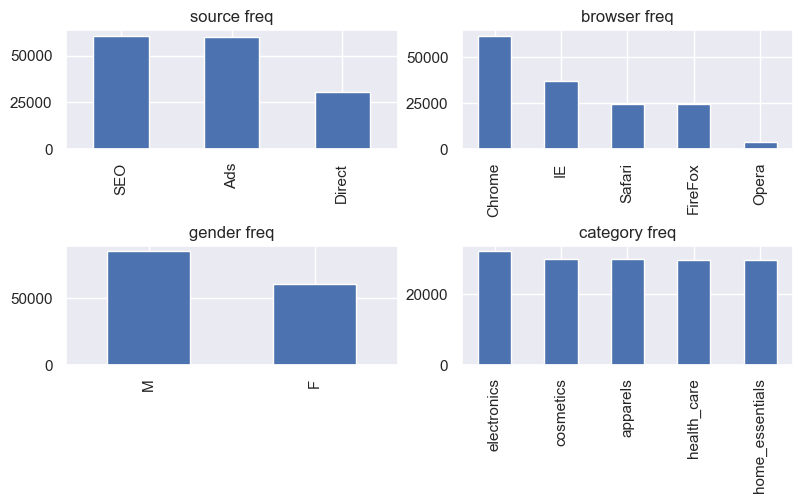

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(8,5))

df['source'].value_counts().plot(kind='bar',title=('source freq'),ax=ax[0,0])
df['browser'].value_counts().plot(kind='bar',title=('browser freq'), ax=ax[0,1])
df['sex'].value_counts().plot(kind='bar',title=('gender freq'), ax=ax[1,0])
df['category'].value_counts().plot(kind='bar',title=('category freq'), ax=ax[1,1])

fig.tight_layout(pad=0.5)
plt.show()

**Inferences**

- Most users using `Chrome browser` for e-commerce.
- Male users are greater in number than Female users.
- All Purchase categories are common, `electronics` category comparatively more.
- Most customers reached e-commerce platform via `Ads, SEO` rather than direct.

### 2b. Multivariate analysis to identify relationships

Exploring relationships w.r.t features and target variable.


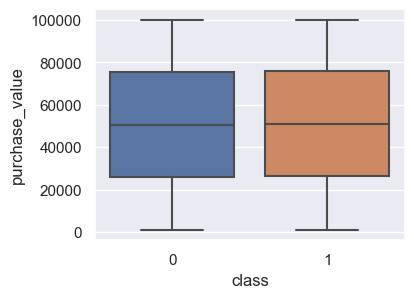

In [51]:
sns.boxplot(x='class', y='purchase_value', data=df);


*There is no significant difference b/w fraud and non-fraud transactions purchase values.*

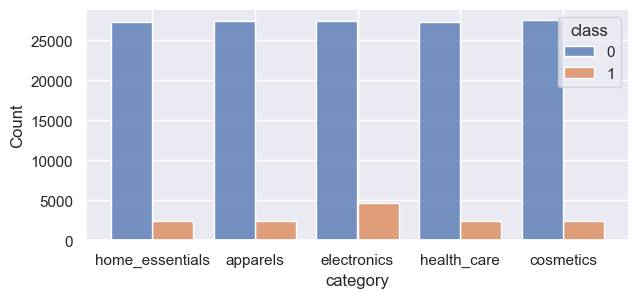

In [52]:
fig, ax1 = plt.subplots(figsize=(7, 3))

sns.histplot(data=df, x="category", hue="class", multiple="dodge", shrink=.8,ax=ax1);


*<font color=blue>Distribution of Item Categories w.r.t Fraud & Non-Fraud classes.Purchase in Electronics category more w.r.t Fraud Class.*

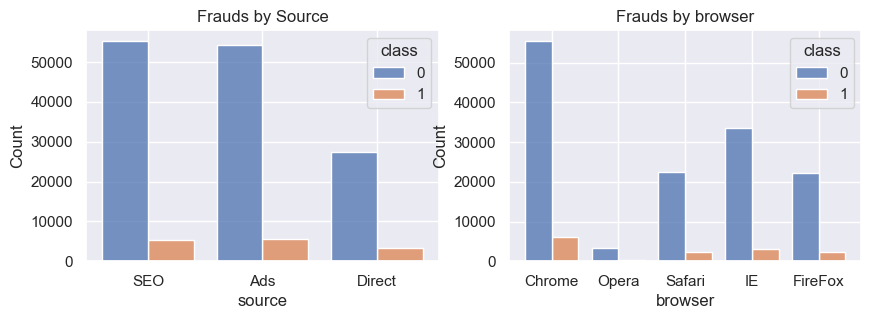

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

sns.histplot(data=df, x="source", hue="class", multiple="dodge", shrink=.8,ax=ax1)
ax1.set_title('Frauds by Source')

sns.histplot(data=df, x="browser", hue="class", multiple="dodge", shrink=.8,ax=ax2)
ax2.set_title('Frauds by browser');



*There is no noticable difference b/w fraud and non-fraud transactions w.r.t source & browser.*

Exploring correlations among features to check for multicollinearity


In [54]:
corr_matrix = df.corr()

/var/folders/1j/6bqwtp0x00z_279498pht7ym0000gn/T/ipykernel_69642/3147368345.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


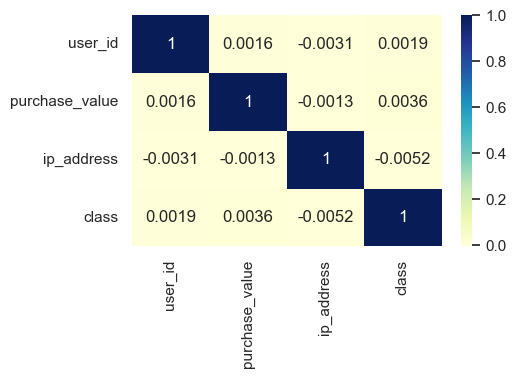

In [55]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(corr_matrix, cmap="YlGnBu",annot=True);

*There are no noticable correlations from above correlation matrix.* 

# 3. Base Model for Benchmark (without Feature Engineering)


In [56]:
df.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,57296,YSSKYOSJHPPLJ,SEO,Opera,M,2.621474e+09,1,electronics,5-3-1962


- We do not consider high cardinality columns as they are like identifier columns & do not help in learning patterns/generalizations w.r.t modelling.
- We would need to feature engineer columns like 'signup_time', 'purchase_time', 'dob', so initially for baseline we build a decision tree without feature engineered columns.
- Columns `'purchase_value', 'source','browser','sex','category','class'` are included below for modelling.


In [57]:
df_base = df[['purchase_value', 'source','browser','sex','category','class']]
df_base.head(3)

,purchase_value,source,browser,sex,category,class
0,65278,SEO,Chrome,M,home_essentials,0
1,96399,Ads,Chrome,F,apparels,0
2,57296,SEO,Opera,M,electronics,1


In [58]:
missing = df_base.isnull().sum()
missing

purchase_value       0
source               0
browser              0
sex               4927
category             0
class                0
dtype: int64

**Split data into Train and Test**

In [59]:
# Create dependent and independent feature sets
X = df_base.drop(columns='class')
y = df_base['class']


# Spilt the data set in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 33)

print(X_train.shape)
print(X_test.shape)

(120889, 5)
(30223, 5)


In [60]:
X_train.head(3)

,purchase_value,source,browser,sex,category
142653,66434,Ads,Chrome,M,cosmetics
29572,92750,Ads,Chrome,M,home_essentials
87134,43704,Ads,FireFox,F,apparels


In [61]:
imputer = SimpleImputer(strategy='most_frequent')
X_train['sex'] = imputer.fit_transform(X_train[['sex']])
X_test['sex'] = imputer.transform(X_test[['sex']])

/var/folders/1j/6bqwtp0x00z_279498pht7ym0000gn/T/ipykernel_69642/4212879512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['sex'] = imputer.fit_transform(X_train[['sex']])
/var/folders/1j/6bqwtp0x00z_279498pht7ym0000gn/T/ipykernel_69642/4212879512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['sex'] = imputer.transform(X_test[['sex']])


**One Hot encoding for Categorical Variables**

The four categorical features `'source','browser','sex','category'` need to be one hot encoded before can be fed to ML algorithm.

In [62]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# Fit on train data
ohe.fit(X_train[['source','browser','sex','category']])


OneHotEncoder()

In [63]:
# Transform on Test Data
X_train_ohe = ohe.transform(X_train[['source','browser','sex','category']])
X_test_ohe = ohe.transform(X_test[['source','browser','sex','category']])


In [64]:
X_train_ohe_df = pd.DataFrame(X_train_ohe.toarray(), 
              columns=ohe.get_feature_names(['source','browser','sex','category']),index=X_train.index)
                             
X_test_ohe_df = pd.DataFrame(X_test_ohe.toarray(), 
              columns=ohe.get_feature_names(['source','browser','sex','category']),index=X_test.index)


In [65]:
X_train_ohe_df.head(3)

,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,category_apparels,category_cosmetics,category_electronics,category_health_care,category_home_essentials
142653,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
29572,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
87134,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [66]:
concat_X_train = pd.concat([X_train, X_train_ohe_df], axis=1)
concat_X_test = pd.concat([X_test, X_test_ohe_df], axis=1)


concat_X_train.drop(['source','browser','sex','category'],axis=1, inplace=True) 
concat_X_test.drop(['source','browser','sex','category'],axis=1, inplace=True) 
# drop the original categorical columns

print(concat_X_train.shape)
print(concat_X_test.shape)

concat_X_train.head(3)


(120889, 16)
(30223, 16)


,purchase_value,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,category_apparels,category_cosmetics,category_electronics,category_health_care,category_home_essentials
142653,66434,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
29572,92750,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
87134,43704,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Now since all columns are numerical, the dataset is ready for modelling.

# Decision Tree Classification Model

In [67]:
from sklearn.tree import DecisionTreeClassifier


In [68]:
# Instantiate and Fit
clf = DecisionTreeClassifier(criterion='gini',   # Default Scikit Learn Parameters
                             max_depth=None,
                             random_state=80)   
clf.fit(concat_X_train,y_train)


DecisionTreeClassifier(random_state=80)

In [69]:
pd.Series(clf.feature_importances_ ,
          index = concat_X_train.columns).sort_values(ascending=False).head(10)


purchase_value              0.887909
category_apparels           0.012768
sex_M                       0.012230
category_cosmetics          0.012103
sex_F                       0.011605
category_home_essentials    0.011196
category_health_care        0.010499
category_electronics        0.008032
browser_Chrome              0.007970
source_Ads                  0.005618
dtype: float64

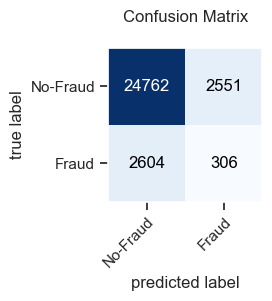

In [70]:
y_pred = clf.predict(concat_X_test)     #  If predicion > 0.5, u get 1 and else 0
cm=confusion_matrix(y_test,y_pred,labels=(0,1))
fig = plot_confusion_matrix(cm, class_names=['No-Fraud','Fraud'],figsize=(2,2))
plt.title("Confusion Matrix\n")
plt.show();

In [71]:
print("Accuracy(in %):", accuracy_score(y_test, y_pred)*100)

print("F1 Score(in %):", f1_score(y_test,y_pred)*100)


Accuracy(in %): 82.94345366111901
F1 Score(in %): 10.612103346627363


# 4. Feature Engineering

### Transforming raw data into features that are suitable for analysis.

<font color=blue> *We mainly take 3 features for engineering which are `signup_time`, `purchase_time` and `dob` from which we extract transaction information related to date, time and users information related to age.*

- signup_time, purchase_time features need to be converted to datetime and then `month, day, hour` is extracted from these columns.
- Also we make a new feature `delta_days` to	compute **difference between purchase time and signup time**
- Also we make a new feature `age` to get the **users age from date of birth column.**

In [72]:
df.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,ip_address,class,category,dob
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,65278,QVPSPJUOCKZAR,SEO,Chrome,M,7.327584e+08,0,home_essentials,22-2-1976
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,96399,EOGFQPIZPYXFZ,Ads,Chrome,F,3.503114e+08,0,apparels,2-1-1962
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,57296,YSSKYOSJHPPLJ,SEO,Opera,M,2.621474e+09,1,electronics,5-3-1962


In [73]:
# Convert to datetime
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

In [74]:
print(df['signup_time'].min(), df['signup_time'].max())
print(df['purchase_time'].min(),df['purchase_time'].max())


2015-01-01 00:00:42 2015-08-18 04:40:29
2015-01-01 00:00:44 2015-12-16 02:56:05


The data is only for one year which is year 2015. Since year is same for all transactions we only extract the month, date and hour of transaction.

In [75]:
# Date Information
df['signup_month'] = df['signup_time'].dt.month
df['signup_day'] = df['signup_time'].dt.day
df['signup_hour'] = df['signup_time'].dt.hour


df['purchase_month'] = df['purchase_time'].dt.month
df['purchase_day'] = df['purchase_time'].dt.day
df['purchase_hour'] = df['purchase_time'].dt.hour


We create new feature to calculate the time difference in days between signup time and purchase time.

In [76]:
# Time information
from datetime import date, timedelta, datetime
df['signup_date'] = df['signup_time'].dt.date
df['purchase_date'] = df['purchase_time'].dt.date

df['delta_days'] = df['purchase_date']-df['signup_date']
df['delta_days'] = df['delta_days'].dt.days


In [77]:
# Age Information
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df['dob'] = pd.to_datetime(df['dob'], format='%d-%m-%Y')
df['age_years'] = ((df['purchase_date'] - df['dob']).dt.days / 365.25).round()

# Create age buckets using binning
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
df['age_bucket'] = pd.cut(df['age_years'], bins=bins, labels=labels)


### Visualizing age_years and age_bucket columns

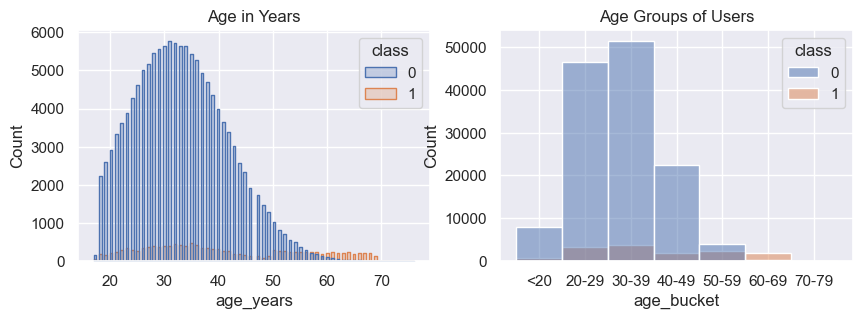

In [78]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))


sns.histplot(data=df, x="age_years", hue="class", element="step", ax=ax1);
ax1.set_title('Age in Years')

sns.histplot(data=df, x="age_bucket", hue="class", ax=ax2)
ax2.set_title('Age Groups of Users');



*<font color=blue>`Age group 60-69` is clearly distinguisable w.r.t Fraud detection as most transaction for this age group only belong to Fraud Class.*

### Visualizing purchase_value and age_bucket columns w.r.t Fraud Transcations

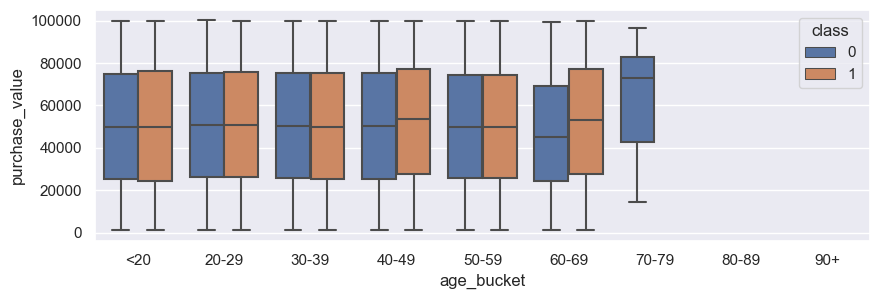

In [79]:
fig, ax1 = plt.subplots(figsize=(10, 3))

sns.boxplot(x='age_bucket', y='purchase_value', hue='class', data=df);


*<font color=blue>For Age groups `'40-49'` and `'60-69'` the median purchase value is higher w.r.t Fraud Class.*

In [80]:
df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'ip_address', 'class',
       'category', 'dob', 'signup_month', 'signup_day', 'signup_hour',
       'purchase_month', 'purchase_day', 'purchase_hour', 'signup_date',
       'purchase_date', 'delta_days', 'age_years', 'age_bucket'],
      dtype='object')

In [81]:
# New Features 
df_new = pd.DataFrame(df, columns=(['signup_month', 'signup_day', 'signup_hour','purchase_month','purchase_day',
        'purchase_hour','delta_days','age_years','class']),index=df.index)


In [82]:
df_new.isnull().sum()

signup_month         0
signup_day           0
signup_hour          0
purchase_month       0
purchase_day         0
purchase_hour        0
delta_days           0
age_years         4924
class                0
dtype: int64

In [83]:
# Create dependent and independent feature sets
X_n = df_new.drop(columns='class')
y_n = df_new['class']


# Spilt the data set in training and testing set
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n,y_n, test_size = 0.20, random_state = 33)


In [84]:
# Imputer for Median age 

imputer = SimpleImputer(strategy='median')  # mean & median age almost same in this data
X_train_n['age_years'] = imputer.fit_transform(X_train_n[['age_years']])
X_test_n['age_years'] = imputer.transform(X_test_n[['age_years']])

/var/folders/1j/6bqwtp0x00z_279498pht7ym0000gn/T/ipykernel_69642/3297869172.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_n['age_years'] = imputer.fit_transform(X_train_n[['age_years']])
/var/folders/1j/6bqwtp0x00z_279498pht7ym0000gn/T/ipykernel_69642/3297869172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_n['age_years'] = imputer.transform(X_test_n[['age_years']])


In [85]:
concat_X_train.head()   # Original Features

,purchase_value,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,category_apparels,category_cosmetics,category_electronics,category_health_care,category_home_essentials
142653,66434,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
29572,92750,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
87134,43704,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
47432,41937,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
124833,58523,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [86]:
X_train_n.head()      # New Features

,signup_month,signup_day,signup_hour,purchase_month,purchase_day,purchase_hour,delta_days,age_years
142653,7,24,21,8,30,6,37,38.0
29572,5,26,8,6,11,18,16,37.0
87134,4,7,16,8,2,11,117,47.0
47432,7,9,8,7,30,5,21,23.0
124833,7,31,23,8,4,11,4,27.0


In [87]:
# Concatenated (Original Features + New Features)
X_train_f = pd.concat([concat_X_train, X_train_n], axis=1)
X_test_f = pd.concat([concat_X_test, X_test_n], axis=1)

print(X_train_f.shape, X_test_f.shape)


(120889, 24) (30223, 24)


### Correlation Matrix after Feature Engineering

In [88]:
df_new.drop('class', axis=1,inplace=True) 
df_corr = pd.concat([df_new, df_base], axis=1)

/var/folders/1j/6bqwtp0x00z_279498pht7ym0000gn/T/ipykernel_69642/1173456829.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix1 = df_corr.corr()


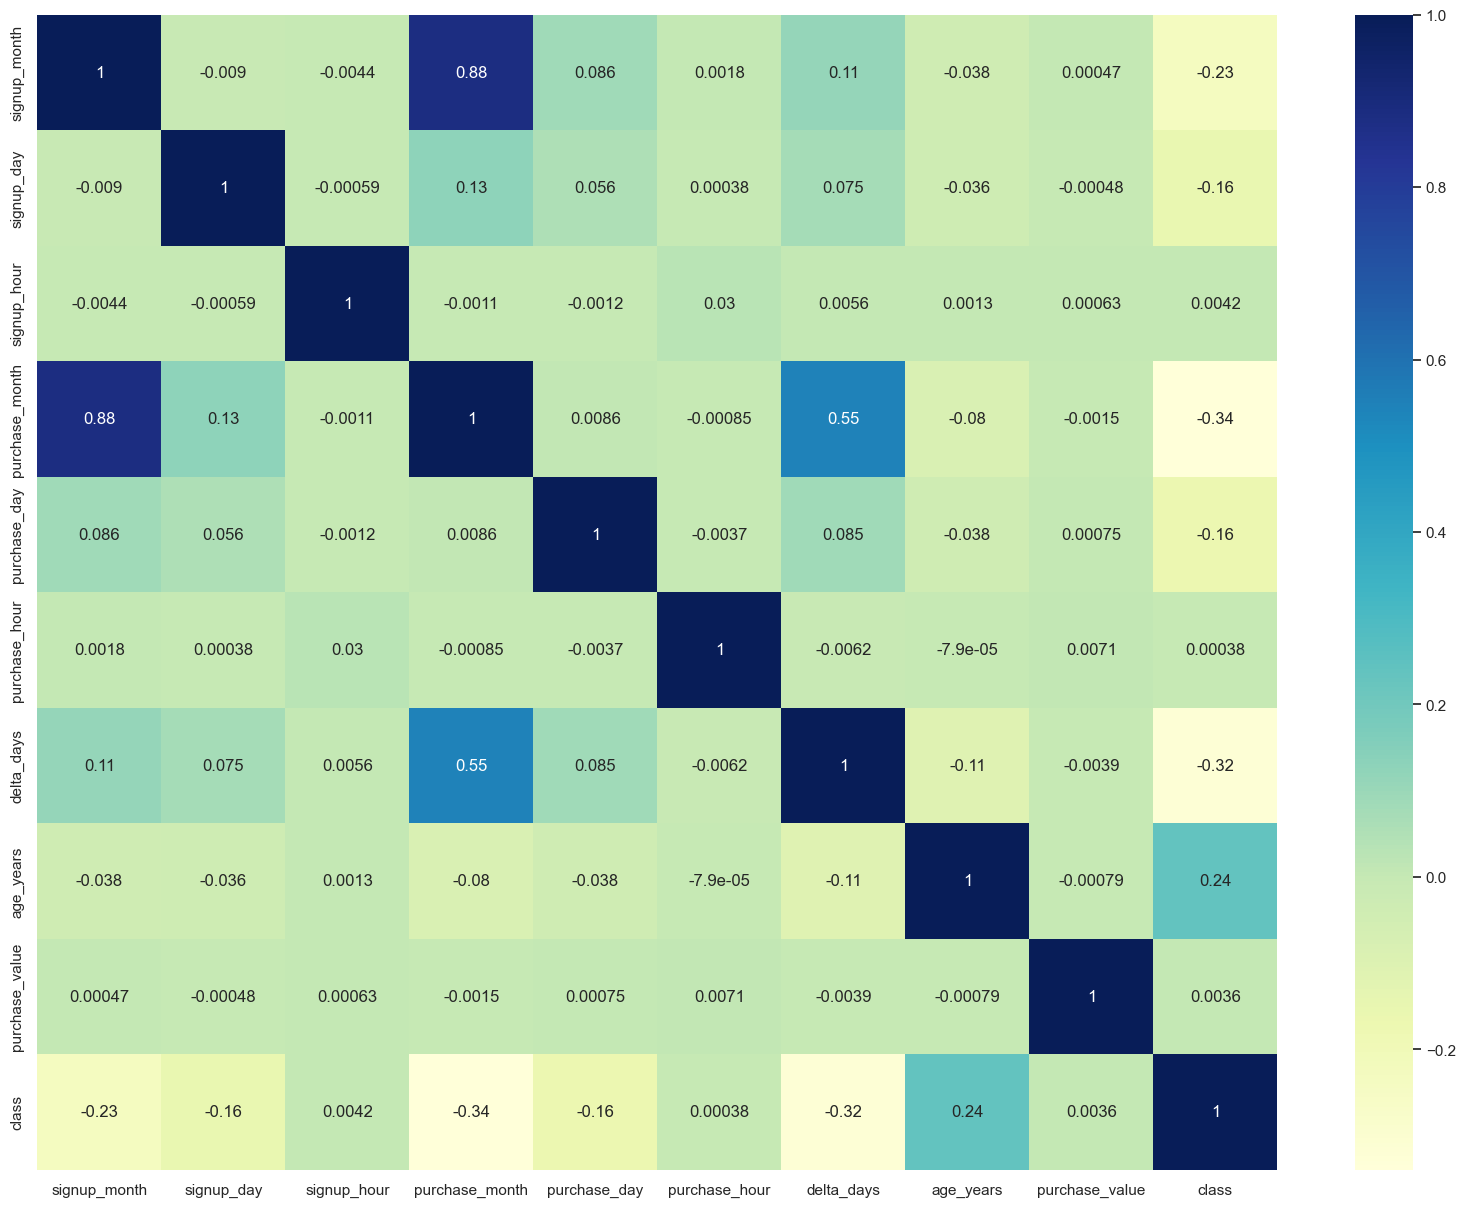

In [89]:
corr_matrix1 = df_corr.corr()
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(corr_matrix1, cmap="YlGnBu",annot=True);

`purchase_month` is highly correlated with signup_month as well as delta_days feature so we drop this feature.

In [90]:
X_train_f.drop('purchase_month', axis=1,inplace=True) 
X_test_f.drop('purchase_month', axis=1,inplace=True) 

print(X_train_f.shape, X_test_f.shape)

(120889, 23) (30223, 23)


# 5. Model Training


*Now we run models on `Enhanced Feature Set` after Feature Engineering. Initially we will use default parameters of Scikit Learn and later we use GridSearch CV for hyperparameter Tuning.*

# 5a. Decision Tree Classifier

In [91]:
X_train_f.columns

Index(['purchase_value', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'category_apparels',
       'category_cosmetics', 'category_electronics', 'category_health_care',
       'category_home_essentials', 'signup_month', 'signup_day', 'signup_hour',
       'purchase_day', 'purchase_hour', 'delta_days', 'age_years'],
      dtype='object')

In [92]:
clf.fit(X_train_f,y_train)     # Default Values of parameters


DecisionTreeClassifier(random_state=80)

In [93]:
pd.Series(clf.feature_importances_ ,
          index = X_train_f.columns).sort_values(ascending=False).head(10)


delta_days         0.582990
age_years          0.094109
purchase_value     0.073797
signup_month       0.054859
signup_day         0.038295
signup_hour        0.036281
purchase_hour      0.036120
purchase_day       0.030594
browser_FireFox    0.006135
browser_IE         0.004931
dtype: float64

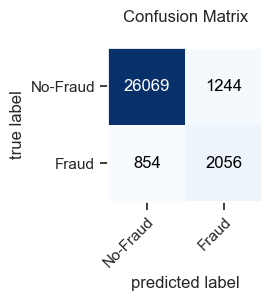

In [94]:
y_pred1 = clf.predict(X_test_f)     #  If predicion > 0.5, u get 1 and else 0
cm1=confusion_matrix(y_test,y_pred1,labels=(0,1))
fig = plot_confusion_matrix(cm1, class_names=['No-Fraud','Fraud'],figsize=(2,2))
plt.title("Confusion Matrix\n")
plt.show();

In [95]:
acc1 = accuracy_score(y_test, y_pred1)*100
print("Accuracy(in %):", acc1)

fscore1 = f1_score(y_test,y_pred1)*100
print("F1 Score(in %):", fscore1)

Accuracy(in %): 93.05826688283757
F1 Score(in %): 66.21578099838969


In [96]:
print(classification_report(y_test, y_pred1))


              precision    recall  f1-score   support

           0       0.97      0.95      0.96     27313
           1       0.62      0.71      0.66      2910

    accuracy                           0.93     30223
   macro avg       0.80      0.83      0.81     30223
weighted avg       0.94      0.93      0.93     30223



*<font color=blue>Accuracy moved up to 93% from 82% and F1 Score moved up to 66% from 10% in comparison to Baseline Model without any feature engineering.*
    

# 5b. Parallel Ensemble - Random Forest Classifier

In [97]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,   # Default Values of parameters
                            criterion='gini',
                            max_depth=None, 
                            random_state=1).fit(X_train_f,y_train) 
# n_estimators: no of trees to build


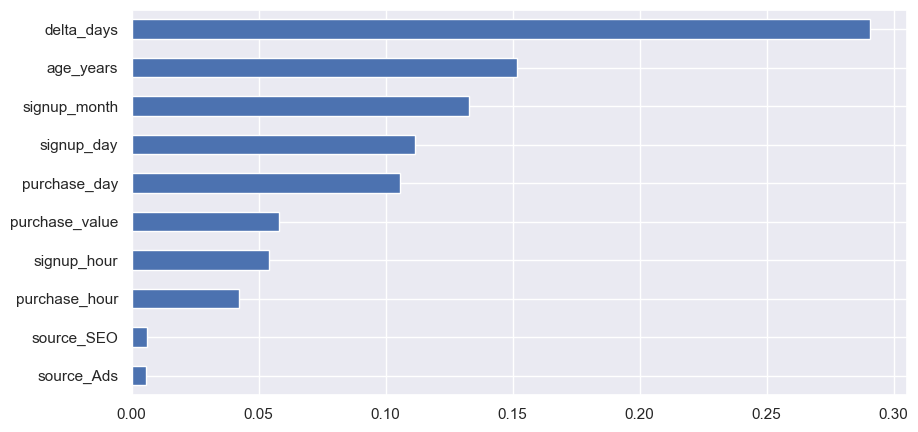

In [98]:
# Feature Importance by 1st Tree in Random Forest

pd.Series(rf.estimators_[0].feature_importances_, index=X_train_f.columns).sort_values(ascending=False).head(10)[::-1].plot.barh(figsize=(10,5));


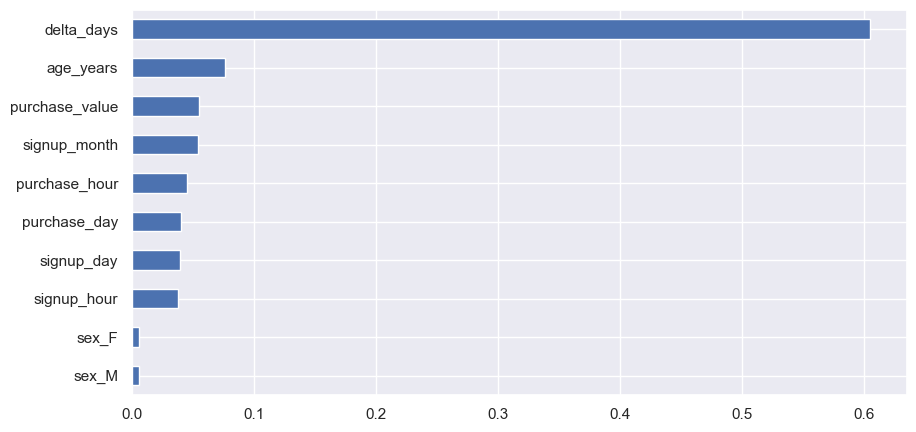

In [99]:
# Feature Importance by 5th Tree in Random Forest

pd.Series(rf.estimators_[5].feature_importances_, index=X_train_f.columns).sort_values(ascending=False).head(10)[::-1].plot.barh(figsize=(10,5));


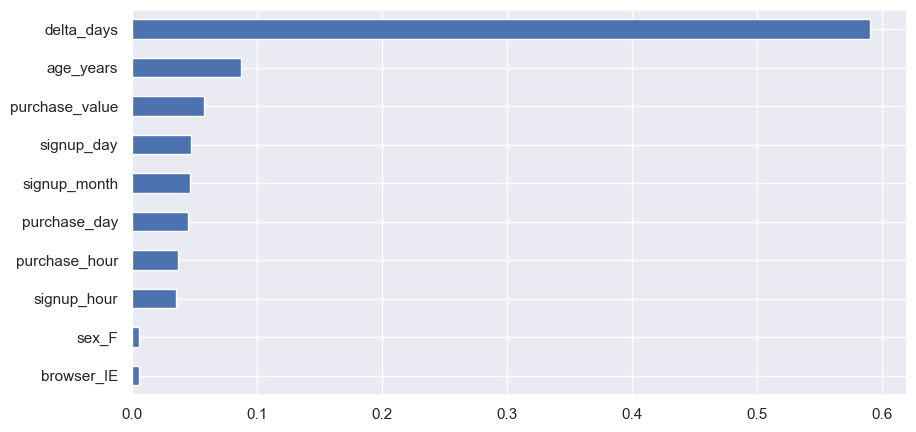

In [100]:
# Feature Importance by 40th Tree in Random Forest
 
pd.Series(rf.estimators_[9].feature_importances_, index=X_train_f.columns).sort_values(ascending=False).head(10)[::-1].plot.barh(figsize=(10,5));


*<font color=blue> Different feature importance given by each tree/estimator in Random Forest.*

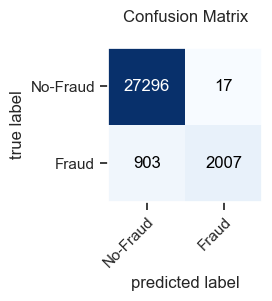

In [101]:
y_pred2 = rf.predict(X_test_f)     #  If predicion > 0.5, u get 1 and else 0
cm2=confusion_matrix(y_test,y_pred2,labels=(0,1))
fig = plot_confusion_matrix(cm2, class_names=['No-Fraud','Fraud'],figsize=(2,2))
plt.title("Confusion Matrix\n")
plt.show();

In [102]:
acc2 = accuracy_score(y_test, y_pred2)*100
print("Accuracy(in %):", acc2)

fscore2 = f1_score(y_test,y_pred2)*100
print("F1 Score(in %):", fscore2)

Accuracy(in %): 96.95596069218807
F1 Score(in %): 81.35387109850019


In [103]:
print(classification_report(y_test, y_pred2))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27313
           1       0.99      0.69      0.81      2910

    accuracy                           0.97     30223
   macro avg       0.98      0.84      0.90     30223
weighted avg       0.97      0.97      0.97     30223



*<font color=blue>Random Forest gives an accuracy of 96% and F1 Score of 81%*

# 5c. Sequential Ensemble - Gradient Boosting

In [104]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100,   # Default Values of parameters
                                criterion='friedman_mse',
                                max_depth=3)

gb.fit(X_train_f, y_train)


GradientBoostingClassifier()

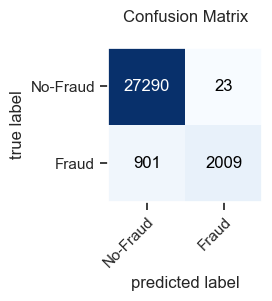

In [105]:
y_pred3 = gb.predict(X_test_f)     #  If predicion > 0.5, u get 1 and else 0
cm3=confusion_matrix(y_test,y_pred3,labels=(0,1))
fig = plot_confusion_matrix(cm3, class_names=['No-Fraud','Fraud'],figsize=(2,2))
plt.title("Confusion Matrix\n")
plt.show();

In [106]:
acc3 = accuracy_score(y_test, y_pred3)*100
print("Accuracy(in %):", acc3)

fscore3 = f1_score(y_test,y_pred3)*100
print("F1 Score(in %):", fscore3)

Accuracy(in %): 96.94272573867583
F1 Score(in %): 81.30311614730877


In [107]:
df = pd.DataFrame({'Model_Name': ['Decision Tree', 'Random Forest', 'Gradient Boosting'],
                   
                   'Accuracy_Test': [acc1, acc2, acc3],
                                     
                   'F1_Test': [fscore1, fscore2, fscore3]})


sorted_df = df.sort_values(['F1_Test','Accuracy_Test'], 
                           ascending=[False, False,])

sorted_df

,Model_Name,Accuracy_Test,F1_Test
1,Random Forest,96.955961,81.353871
2,Gradient Boosting,96.942726,81.303116
0,Decision Tree,93.058267,66.215781


*We further do hyperparameter tuning for random forest which gives better performance in comparison to other two models*

# 6. Hyperparameter Tuning

*<font color=blue>We first do RandomSearch and then based on its results go for GridSearch CV*

In [108]:
params = {'n_estimators': [100, 200, 300],
              'max_depth': [2, 5, 10],
              'min_samples_split': [2, 5, 10],
              'bootstrap': [True]}


rf_rs = RandomizedSearchCV(estimator=rf, 
                          param_distributions=params, # parameters in which we want to search optimal values
                          scoring='f1', 
                          cv=5,n_jobs=-1).fit(X_train_f, y_train)


# Print the best hyperparameters and evaluation scores
print('Best hyperparameters:', rf_rs.best_params_)
print('Best F1 score:', rf_rs.best_score_)


Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': 10, 'bootstrap': True}
Best F1 score: 0.7975655705241718


In [109]:
params = {'n_estimators': [270, 300, 330],
              'max_depth': [8, 10, 12],
              'min_samples_split': [4, 8, 12]}
              

rf_gs = GridSearchCV(estimator=rf, 
                      param_grid=params, # parameters in which we want to search optimal values
                      scoring='f1', 
                      cv=5,n_jobs=-1).fit(X_train_f, y_train)


# Print the best hyperparameters and evaluation scores
print('Best hyperparameters:', rf_gs.best_params_)
print('Best F1 score:', rf_gs.best_score_)



/Users/sylvia/opt/anaconda3/envs/tf_dl/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'max_depth': 12, 'min_samples_split': 4, 'n_estimators': 270}
Best F1 score: 0.7976084395169354


In [110]:
# Fit on Hyperparameter Tuned Model

rf_gs.fit(X_train_f, y_train)

y_pred4 = rf_gs.predict(X_test_f)     


acc4 = accuracy_score(y_test, y_pred4)*100
print("Accuracy(in %):", acc4)

fscore4 = f1_score(y_test,y_pred4)*100
print("F1 Score(in %):", fscore4)


Accuracy(in %): 96.9691956457003
F1 Score(in %): 81.42741281427413


# 7. Model Evaluation and ROC Curves

## ROC & AUC Evaluations

In [111]:
from scikitplot.metrics import plot_roc


In [112]:
# We get predicted probabilities from all 3 models

y_dt =  clf.predict_proba(X_test_f) 
y_rf =  rf_gs.predict_proba(X_test_f) 
y_gb =  gb.predict_proba(X_test_f) 


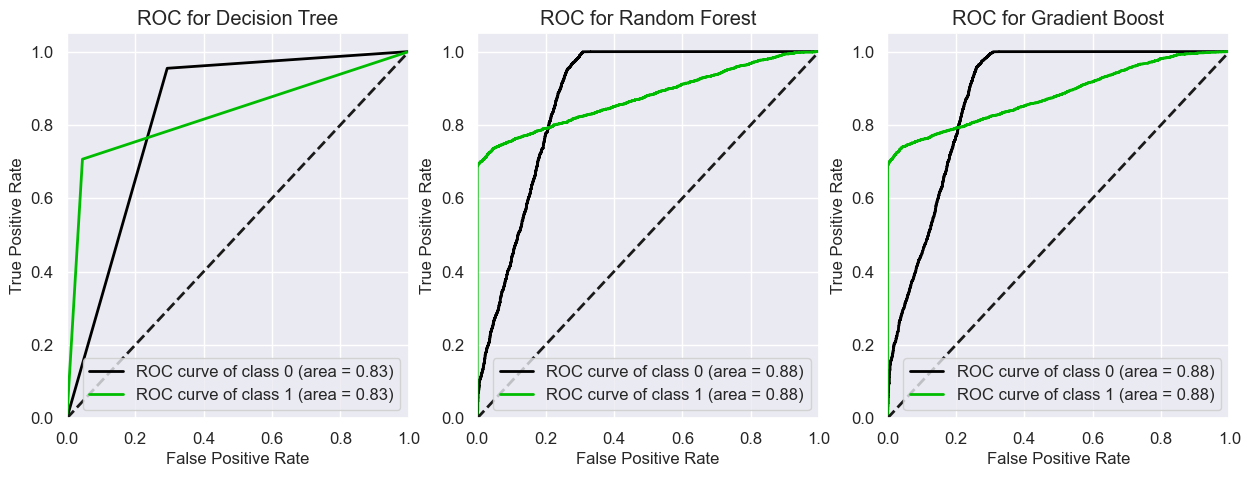

In [113]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

plot_roc(y_test,y_dt,figsize=(5,3),title='ROC for Decision Tree',
        plot_micro=False,
        plot_macro=False,ax=ax[0]);

plot_roc(y_test,y_rf,figsize=(5,3),title='ROC for Random Forest',
        plot_micro=False,
        plot_macro=False,ax=ax[1]);

plot_roc(y_test,y_gb,figsize=(5,3),title='ROC for Gradient Boost',
        plot_micro=False,
        plot_macro=False,ax=ax[2]);

*<font color=blue>In terms of Accuracy Random Forest is better while in terms of AUC Gradient Boost gives better result*

# Objective 2

## Customer Segmentation using K-means Clustering 

In [114]:
# Dataframe with all engineered features
df_corr.columns

Index(['signup_month', 'signup_day', 'signup_hour', 'purchase_month',
       'purchase_day', 'purchase_hour', 'delta_days', 'age_years',
       'purchase_value', 'source', 'browser', 'sex', 'category', 'class'],
      dtype='object')

In [115]:
# Only include customer relevant features for segmentation & drop rest

df_cust = df_corr.drop(['signup_month', 'signup_day', 'signup_hour','purchase_month',
                        'purchase_day', 'purchase_hour', 'delta_days','class','source',
                        'browser'],axis=1)


In [116]:
df_cust.head(3)

,age_years,purchase_value,sex,category
0,39.0,65278,M,home_essentials
1,53.0,96399,F,apparels
2,53.0,57296,M,electronics


In [117]:
from sklearn.preprocessing import OneHotEncoder

df_cust_ohe = pd.get_dummies(df_cust)


In [118]:
df_cust_ohe.head(3)

,age_years,purchase_value,sex_F,sex_M,category_apparels,category_cosmetics,category_electronics,category_health_care,category_home_essentials
0,39.0,65278,0,1,0,0,0,0,1
1,53.0,96399,1,0,1,0,0,0,0
2,53.0,57296,0,1,0,0,1,0,0


In [119]:
df_cust_ohe.isnull().sum()


age_years                   4924
purchase_value                 0
sex_F                          0
sex_M                          0
category_apparels              0
category_cosmetics             0
category_electronics           0
category_health_care           0
category_home_essentials       0
dtype: int64

In [120]:
imputer = SimpleImputer(strategy='median')
df_cust_ohe['age_years'] = imputer.fit_transform(df_cust_ohe[['age_years']])


*<font color=blue>As K means is a distance based algorithm, so we normalize the features*

In [121]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

df_cust_norm = std.fit_transform(df_cust_ohe)


In [122]:
### Initially apply K means with k = 3

In [123]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init="k-means++")
kmeans.fit(df_cust_norm)


KMeans(n_clusters=3)

In [124]:
kmeans.labels_

array([1, 2, 1, ..., 0, 1, 1], dtype=int32)

In [125]:
kmeans.cluster_centers_

array([[-3.43471515e-02,  2.11997084e-03,  9.20701533e-04,
         1.33225320e-03, -4.95317695e-01, -4.97078249e-01,
        -5.18894445e-01,  2.02233312e+00, -4.94146711e-01],
       [ 1.56759395e-02,  1.14794147e-03, -8.19823658e-01,
         7.65777277e-01,  1.19408853e-01,  1.19162941e-01,
         1.29349116e-01, -4.94478377e-01,  1.22364603e-01],
       [-2.43499902e-03, -2.99868430e-03,  1.21977451e+00,
        -1.14069553e+00,  1.23641137e-01,  1.25078428e-01,
         1.23190435e-01, -4.94478377e-01,  1.18528899e-01]])

### Decide on optimal number of k (clusters) to perform K means Clustering

In [126]:
#Deciding Optimal Number of CLusters:
from sklearn.metrics import davies_bouldin_score
sse,db = {}, {}
for k in range(2, 20):
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=10).fit(df_cust_norm)
    labels=kmeans.predict(df_cust_norm)
    sse[k] = kmeans.inertia_ 
    # Inertia: Sum of squared distances of samples to their closest cluster center
    db[k] = davies_bouldin_score(df_cust_norm,labels)

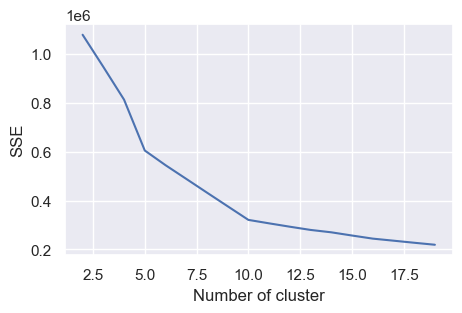

In [127]:
#Elbow Method
plt.figure(figsize=(5,3))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

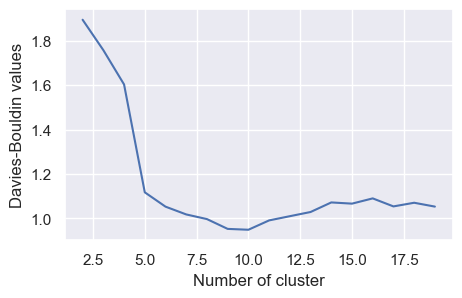

In [128]:
#Davis-Boldin index
plt.figure(figsize=(5,3))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

*<font color=blue> We observe that `Elbow method` as well as `DB Index` gives k=5, hence we do K-means Clustering with k=5*

### Apply k-means clustering with k=5

In [129]:
kmeans = KMeans(n_clusters=5, max_iter=10000)
kmeans.fit(df_cust_norm)
labels = kmeans.predict(df_cust_norm)

### Evaluation metric - Silhoutte Score

In [130]:
from sklearn.metrics import silhouette_score
score = silhouette_score(df_cust_norm, labels, metric='euclidean')
# Print the score
print('Silhouetter Score: %.3f' % score)
    

Silhouetter Score: 0.420


*<font color=blue> We get a Silhoutte Score of 0.42 for the K-means Clustering*

### Cluster Profiles 

In [131]:
# Define function

def get_z_profiles(data1, Kmean):
    data1['Labels']=Kmean.labels_
    profile = data1.groupby('Labels').mean().subtract(data1.drop('Labels',axis=1).mean(),axis=1)
    profile=profile.divide(data1.drop('Labels',axis=1).std(),axis=1)
    profile['Count'] = data1['Labels'].value_counts()
    return profile


In [132]:
# Call Function

df_cust_norm1 = pd.DataFrame(df_cust_norm)
get_z_profiles(data1=df_cust_norm1,Kmean=kmeans)

,0,1,2,3,4,5,6,7,8,Count
Labels,,,,,,,,,,
0,-0.034347,0.002120,0.000921,0.001332,-0.495316,-0.497077,-0.518893,2.022326,-0.494145,29689
1,-0.022835,0.006609,0.004463,-0.006288,-0.495316,2.011749,-0.518893,-0.494477,-0.494145,29940
2,0.084380,0.002383,-0.004901,0.002782,-0.495316,-0.497077,1.927168,-0.494477,-0.494145,32056
3,-0.016733,-0.005484,-0.003283,0.004605,-0.495316,-0.497077,-0.518893,-0.494477,2.023684,29657
4,-0.016971,-0.005865,0.003141,-0.002588,2.018900,-0.497077,-0.518893,-0.494477,-0.494145,29770


*We have 5 clusters as shown above with their corresponding counts*